<h5>Importing Required Libraries</h5>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.devnet import DevNet
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

<h5>Importing and Merging the Datasets</h5>

In [6]:
folder_path = "datasets"
file_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.csv')]
merged_df = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in file_list], ignore_index = True)
merged_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


<h5>Data Cleaning & Exploratory Data Analysis</h5>

In [7]:
merged_df.shape

(2830743, 79)

In [8]:
merged_df.columns = merged_df.columns.str.strip().str.upper().str.replace(' ', '_')
merged_df.columns

Index(['DESTINATION_PORT', 'FLOW_DURATION', 'TOTAL_FWD_PACKETS',
       'TOTAL_BACKWARD_PACKETS', 'TOTAL_LENGTH_OF_FWD_PACKETS',
       'TOTAL_LENGTH_OF_BWD_PACKETS', 'FWD_PACKET_LENGTH_MAX',
       'FWD_PACKET_LENGTH_MIN', 'FWD_PACKET_LENGTH_MEAN',
       'FWD_PACKET_LENGTH_STD', 'BWD_PACKET_LENGTH_MAX',
       'BWD_PACKET_LENGTH_MIN', 'BWD_PACKET_LENGTH_MEAN',
       'BWD_PACKET_LENGTH_STD', 'FLOW_BYTES/S', 'FLOW_PACKETS/S',
       'FLOW_IAT_MEAN', 'FLOW_IAT_STD', 'FLOW_IAT_MAX', 'FLOW_IAT_MIN',
       'FWD_IAT_TOTAL', 'FWD_IAT_MEAN', 'FWD_IAT_STD', 'FWD_IAT_MAX',
       'FWD_IAT_MIN', 'BWD_IAT_TOTAL', 'BWD_IAT_MEAN', 'BWD_IAT_STD',
       'BWD_IAT_MAX', 'BWD_IAT_MIN', 'FWD_PSH_FLAGS', 'BWD_PSH_FLAGS',
       'FWD_URG_FLAGS', 'BWD_URG_FLAGS', 'FWD_HEADER_LENGTH',
       'BWD_HEADER_LENGTH', 'FWD_PACKETS/S', 'BWD_PACKETS/S',
       'MIN_PACKET_LENGTH', 'MAX_PACKET_LENGTH', 'PACKET_LENGTH_MEAN',
       'PACKET_LENGTH_STD', 'PACKET_LENGTH_VARIANCE', 'FIN_FLAG_COUNT',
       'SYN_FLAG_CO

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   DESTINATION_PORT             int64  
 1   FLOW_DURATION                int64  
 2   TOTAL_FWD_PACKETS            int64  
 3   TOTAL_BACKWARD_PACKETS       int64  
 4   TOTAL_LENGTH_OF_FWD_PACKETS  int64  
 5   TOTAL_LENGTH_OF_BWD_PACKETS  int64  
 6   FWD_PACKET_LENGTH_MAX        int64  
 7   FWD_PACKET_LENGTH_MIN        int64  
 8   FWD_PACKET_LENGTH_MEAN       float64
 9   FWD_PACKET_LENGTH_STD        float64
 10  BWD_PACKET_LENGTH_MAX        int64  
 11  BWD_PACKET_LENGTH_MIN        int64  
 12  BWD_PACKET_LENGTH_MEAN       float64
 13  BWD_PACKET_LENGTH_STD        float64
 14  FLOW_BYTES/S                 float64
 15  FLOW_PACKETS/S               float64
 16  FLOW_IAT_MEAN                float64
 17  FLOW_IAT_STD                 float64
 18  FLOW_IAT_MAX                 int64  
 19  

In [10]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DESTINATION_PORT,2830743.0,8.071483e+03,1.828363e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
FLOW_DURATION,2830743.0,1.478566e+07,3.365374e+07,-1.300000e+01,155.000000,31316.000000,3.204828e+06,1.200000e+08
TOTAL_FWD_PACKETS,2830743.0,9.361160e+00,7.496728e+02,1.000000e+00,2.000000,2.000000,5.000000e+00,2.197590e+05
TOTAL_BACKWARD_PACKETS,2830743.0,1.039377e+01,9.973883e+02,0.000000e+00,1.000000,2.000000,4.000000e+00,2.919220e+05
TOTAL_LENGTH_OF_FWD_PACKETS,2830743.0,5.493024e+02,9.993589e+03,0.000000e+00,12.000000,62.000000,1.870000e+02,1.290000e+07
TOTAL_LENGTH_OF_BWD_PACKETS,2830743.0,1.616264e+04,2.263088e+06,0.000000e+00,0.000000,123.000000,4.820000e+02,6.554530e+08
FWD_PACKET_LENGTH_MAX,2830743.0,2.075999e+02,7.171848e+02,0.000000e+00,6.000000,37.000000,8.100000e+01,2.482000e+04
FWD_PACKET_LENGTH_MIN,2830743.0,1.871366e+01,6.033935e+01,0.000000e+00,0.000000,2.000000,3.600000e+01,2.325000e+03
FWD_PACKET_LENGTH_MEAN,2830743.0,5.820194e+01,1.860912e+02,0.000000e+00,6.000000,34.000000,5.000000e+01,5.940857e+03
FWD_PACKET_LENGTH_STD,2830743.0,6.891013e+01,2.811871e+02,0.000000e+00,0.000000,0.000000,2.616295e+01,7.125597e+03


In [11]:
merged_df = merged_df.drop('FWD_HEADER_LENGTH.1', axis = 1)
merged_df.shape

(2830743, 78)

In [12]:
inf_count = np.isinf(merged_df.drop('LABEL', axis = 1)).sum()
inf_count

DESTINATION_PORT                  0
FLOW_DURATION                     0
TOTAL_FWD_PACKETS                 0
TOTAL_BACKWARD_PACKETS            0
TOTAL_LENGTH_OF_FWD_PACKETS       0
TOTAL_LENGTH_OF_BWD_PACKETS       0
FWD_PACKET_LENGTH_MAX             0
FWD_PACKET_LENGTH_MIN             0
FWD_PACKET_LENGTH_MEAN            0
FWD_PACKET_LENGTH_STD             0
BWD_PACKET_LENGTH_MAX             0
BWD_PACKET_LENGTH_MIN             0
BWD_PACKET_LENGTH_MEAN            0
BWD_PACKET_LENGTH_STD             0
FLOW_BYTES/S                   1509
FLOW_PACKETS/S                 2867
FLOW_IAT_MEAN                     0
FLOW_IAT_STD                      0
FLOW_IAT_MAX                      0
FLOW_IAT_MIN                      0
FWD_IAT_TOTAL                     0
FWD_IAT_MEAN                      0
FWD_IAT_STD                       0
FWD_IAT_MAX                       0
FWD_IAT_MIN                       0
BWD_IAT_TOTAL                     0
BWD_IAT_MEAN                      0
BWD_IAT_STD                 

In [13]:
merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']] = merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']].replace([np.inf, -np.inf], np.nan)
inf_count = np.isinf(merged_df.drop('LABEL', axis = 1)).sum()
inf_count

DESTINATION_PORT               0
FLOW_DURATION                  0
TOTAL_FWD_PACKETS              0
TOTAL_BACKWARD_PACKETS         0
TOTAL_LENGTH_OF_FWD_PACKETS    0
TOTAL_LENGTH_OF_BWD_PACKETS    0
FWD_PACKET_LENGTH_MAX          0
FWD_PACKET_LENGTH_MIN          0
FWD_PACKET_LENGTH_MEAN         0
FWD_PACKET_LENGTH_STD          0
BWD_PACKET_LENGTH_MAX          0
BWD_PACKET_LENGTH_MIN          0
BWD_PACKET_LENGTH_MEAN         0
BWD_PACKET_LENGTH_STD          0
FLOW_BYTES/S                   0
FLOW_PACKETS/S                 0
FLOW_IAT_MEAN                  0
FLOW_IAT_STD                   0
FLOW_IAT_MAX                   0
FLOW_IAT_MIN                   0
FWD_IAT_TOTAL                  0
FWD_IAT_MEAN                   0
FWD_IAT_STD                    0
FWD_IAT_MAX                    0
FWD_IAT_MIN                    0
BWD_IAT_TOTAL                  0
BWD_IAT_MEAN                   0
BWD_IAT_STD                    0
BWD_IAT_MAX                    0
BWD_IAT_MIN                    0
FWD_PSH_FL

In [14]:
na_count = merged_df.isna().sum()
na_count

DESTINATION_PORT                  0
FLOW_DURATION                     0
TOTAL_FWD_PACKETS                 0
TOTAL_BACKWARD_PACKETS            0
TOTAL_LENGTH_OF_FWD_PACKETS       0
TOTAL_LENGTH_OF_BWD_PACKETS       0
FWD_PACKET_LENGTH_MAX             0
FWD_PACKET_LENGTH_MIN             0
FWD_PACKET_LENGTH_MEAN            0
FWD_PACKET_LENGTH_STD             0
BWD_PACKET_LENGTH_MAX             0
BWD_PACKET_LENGTH_MIN             0
BWD_PACKET_LENGTH_MEAN            0
BWD_PACKET_LENGTH_STD             0
FLOW_BYTES/S                   2867
FLOW_PACKETS/S                 2867
FLOW_IAT_MEAN                     0
FLOW_IAT_STD                      0
FLOW_IAT_MAX                      0
FLOW_IAT_MIN                      0
FWD_IAT_TOTAL                     0
FWD_IAT_MEAN                      0
FWD_IAT_STD                       0
FWD_IAT_MAX                       0
FWD_IAT_MIN                       0
BWD_IAT_TOTAL                     0
BWD_IAT_MEAN                      0
BWD_IAT_STD                 

In [15]:
merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']] = merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']].fillna(merged_df[['FLOW_BYTES/S', 'FLOW_PACKETS/S']].median())
na_count = merged_df.isna().sum()
na_count

DESTINATION_PORT               0
FLOW_DURATION                  0
TOTAL_FWD_PACKETS              0
TOTAL_BACKWARD_PACKETS         0
TOTAL_LENGTH_OF_FWD_PACKETS    0
TOTAL_LENGTH_OF_BWD_PACKETS    0
FWD_PACKET_LENGTH_MAX          0
FWD_PACKET_LENGTH_MIN          0
FWD_PACKET_LENGTH_MEAN         0
FWD_PACKET_LENGTH_STD          0
BWD_PACKET_LENGTH_MAX          0
BWD_PACKET_LENGTH_MIN          0
BWD_PACKET_LENGTH_MEAN         0
BWD_PACKET_LENGTH_STD          0
FLOW_BYTES/S                   0
FLOW_PACKETS/S                 0
FLOW_IAT_MEAN                  0
FLOW_IAT_STD                   0
FLOW_IAT_MAX                   0
FLOW_IAT_MIN                   0
FWD_IAT_TOTAL                  0
FWD_IAT_MEAN                   0
FWD_IAT_STD                    0
FWD_IAT_MAX                    0
FWD_IAT_MIN                    0
BWD_IAT_TOTAL                  0
BWD_IAT_MEAN                   0
BWD_IAT_STD                    0
BWD_IAT_MAX                    0
BWD_IAT_MIN                    0
FWD_PSH_FL

In [16]:
duplicate_count = merged_df.duplicated().sum()
duplicate_count

np.int64(308381)

In [17]:
merged_df = merged_df.drop_duplicates()
duplicate_count = merged_df.duplicated().sum()
duplicate_count

np.int64(0)

In [18]:
merged_df.shape

(2522362, 78)

<h5>Feature Extraction</h5>

In [19]:
merged_df['BINARY_LABEL'] = merged_df['LABEL'].apply(lambda s: 0 if s == "BENIGN" else 1)
X = merged_df.drop(['LABEL', 'BINARY_LABEL'], axis = 1)
y = merged_df['BINARY_LABEL'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h5>Visualization</h5>

In [22]:
label_counts = merged_df['LABEL'].value_counts()
label_counts

LABEL
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

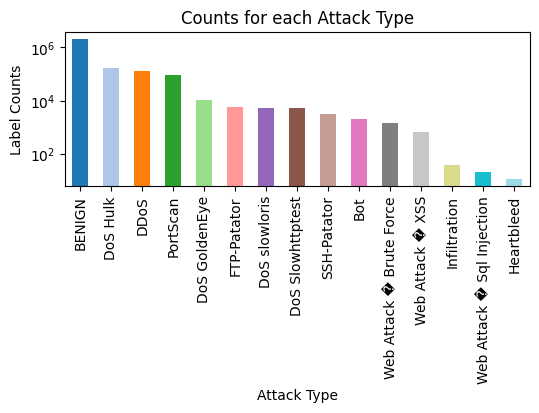

In [23]:
plt.figure(figsize = (6, 2))
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(label_counts)))
label_counts.plot(kind = 'bar', color = colors)
plt.xlabel('Attack Type')
plt.ylabel('Label Counts')
plt.title('Counts for each Attack Type')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [24]:
corr_matrix = X.corr()
corr_matrix

,DESTINATION_PORT,FLOW_DURATION,TOTAL_FWD_PACKETS,TOTAL_BACKWARD_PACKETS,TOTAL_LENGTH_OF_FWD_PACKETS,TOTAL_LENGTH_OF_BWD_PACKETS,FWD_PACKET_LENGTH_MAX,FWD_PACKET_LENGTH_MIN,FWD_PACKET_LENGTH_MEAN,FWD_PACKET_LENGTH_STD,BWD_PACKET_LENGTH_MAX,BWD_PACKET_LENGTH_MIN,BWD_PACKET_LENGTH_MEAN,BWD_PACKET_LENGTH_STD,FLOW_BYTES/S,FLOW_PACKETS/S,FLOW_IAT_MEAN,FLOW_IAT_STD,FLOW_IAT_MAX,FLOW_IAT_MIN,FWD_IAT_TOTAL,FWD_IAT_MEAN,FWD_IAT_STD,FWD_IAT_MAX,FWD_IAT_MIN,BWD_IAT_TOTAL,BWD_IAT_MEAN,BWD_IAT_STD,BWD_IAT_MAX,BWD_IAT_MIN,FWD_PSH_FLAGS,BWD_PSH_FLAGS,FWD_URG_FLAGS,BWD_URG_FLAGS,FWD_HEADER_LENGTH,BWD_HEADER_LENGTH,FWD_PACKETS/S,BWD_PACKETS/S,MIN_PACKET_LENGTH,MAX_PACKET_LENGTH,PACKET_LENGTH_MEAN,PACKET_LENGTH_STD,PACKET_LENGTH_VARIANCE,FIN_FLAG_COUNT,SYN_FLAG_COUNT,RST_FLAG_COUNT,PSH_FLAG_COUNT,ACK_FLAG_COUNT,URG_FLAG_COUNT,CWE_FLAG_COUNT,ECE_FLAG_COUNT,DOWN/UP_RATIO,AVERAGE_PACKET_SIZE,AVG_FWD_SEGMENT_SIZE,AVG_BWD_SEGMENT_SIZE,FWD_AVG_BYTES/BULK,FWD_AVG_PACKETS/BULK,FWD_AVG_BULK_RATE,BWD_AVG_BYTES/BULK,BWD_AVG_PACKETS/BULK,BWD_AVG_BULK_RATE,SUBFLOW_FWD_PACKETS,SUBFLOW_FWD_BYTES,SUBFLOW_BWD_PACKETS,SUBFLOW_BWD_BYTES,INIT_WIN_BYTES_FORWARD,INIT_WIN_BYTES_BACKWARD,ACT_DATA_PKT_FWD,MIN_SEG_SIZE_FORWARD,ACTIVE_MEAN,ACTIVE_STD,ACTIVE_MAX,ACTIVE_MIN,IDLE_MEAN,IDLE_STD,IDLE_MAX,IDLE_MIN
DESTINATION_PORT,1.000000,-0.171828,-0.004652,-0.004356,0.009611,-0.003388,0.090989,-0.047160,0.136916,0.123060,-0.212699,-0.262417,-0.238842,-0.190515,0.070180,0.359015,-0.113636,-0.131931,-0.130869,-0.023383,-0.171004,-0.107032,-0.111044,-0.129597,-0.055521,-0.119856,-0.075871,-0.041670,-0.061670,-0.055113,0.234993,NaN,0.004445,NaN,0.000457,0.000761,0.348251,0.143760,-0.255221,-0.143499,-0.171428,-0.139519,-0.077536,-0.036841,0.234993,-0.007134,-0.217887,0.585195,0.523381,0.004445,-0.007044,0.027562,-0.172832,0.136916,-0.238842,NaN,NaN,NaN,NaN,NaN,NaN,-0.004652,0.009624,-0.004356,-0.003388,-0.133049,0.206231,-0.003543,0.001003,-0.040678,-0.048227,-0.058142,-0.027193,-0.127989,0.006732,-0.123677,-0.129539
FLOW_DURATION,-0.171828,1.000000,0.020571,0.019389,0.063509,0.015998,0.263401,-0.115716,0.134033,0.224957,0.485858,-0.238692,0.448503,0.433671,-0.024965,-0.109823,0.534831,0.734884,0.779979,0.060566,0.998529,0.543119,0.721063,0.779716,0.209850,0.819887,0.408650,0.517722,0.580336,0.212795,-0.017047,NaN,-0.002651,NaN,-0.000097,-0.001049,-0.099488,-0.080348,-0.247385,0.501514,0.417241,0.445197,0.271962,0.217883,-0.017047,0.008075,0.179773,0.033256,-0.117224,-0.002651,0.008023,-0.165840,0.394800,0.134033,0.448503,NaN,NaN,NaN,NaN,NaN,NaN,0.020571,0.063592,0.019389,0.015998,0.094089,-0.034352,0.015728,-0.001236,0.184985,0.238497,0.289933,0.117259,0.764124,0.240369,0.775744,0.734123
TOTAL_FWD_PACKETS,-0.004652,0.020571,1.000000,0.999070,0.365510,0.996993,0.009071,-0.003255,-0.000262,0.001110,0.022552,-0.006068,0.021123,0.006045,0.000391,-0.002340,-0.001366,-0.000954,0.001862,-0.000589,0.020240,-0.001361,-0.000333,0.001418,-0.001290,0.023794,-0.000883,0.000475,0.003095,-0.001144,0.001882,NaN,-0.000059,NaN,0.000476,0.013750,-0.002132,-0.001655,-0.006792,0.021735,0.024239,0.011654,0.005141,-0.001337,0.001882,0.000339,0.007061,0.001378,-0.003794,-0.000059,0.000337,0.000882,0.021865,-0.000262,0.021123,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.365992,0.999070,0.996987,0.003729,-0.000658,0.887386,-0.000181,0.039822,0.008207,0.030318,0.041186,0.001402,0.000676,0.001483,0.001266
TOTAL_BACKWARD_PACKETS,-0.004356,0.019389,0.999070,1.000000,0.359457,0.994430,0.008764,-0.002834,-0.000617,0.000743,0.022342,-0.005343,0.021244,0.005722,0.000335,-0.002382,-0.001711,-0.001426,0.001406,-0.000615,0.019040,-0.001541,-0.000860,0.000947,-0.001160,0.023219,-0.001039,0.000272,0.003177,-0.001100,0.001673,NaN,-0.000061,NaN,0.000757,0.013766,-0.002231,-0.001369,-0.006152,0.021469,0.024655,0.011508,0.005111,-0.001183,0.001673,0.000214,0.006490,0.001203,-0.003151,-0.000061,0.000213,0.003279,0.022290,-0.000617,0.021244,NaN,NaN,NaN,NaN,NaN,NaN,0.999070,0.359939,1.000000,0.994424,0.003167,-0.000660,0.882566,0.0

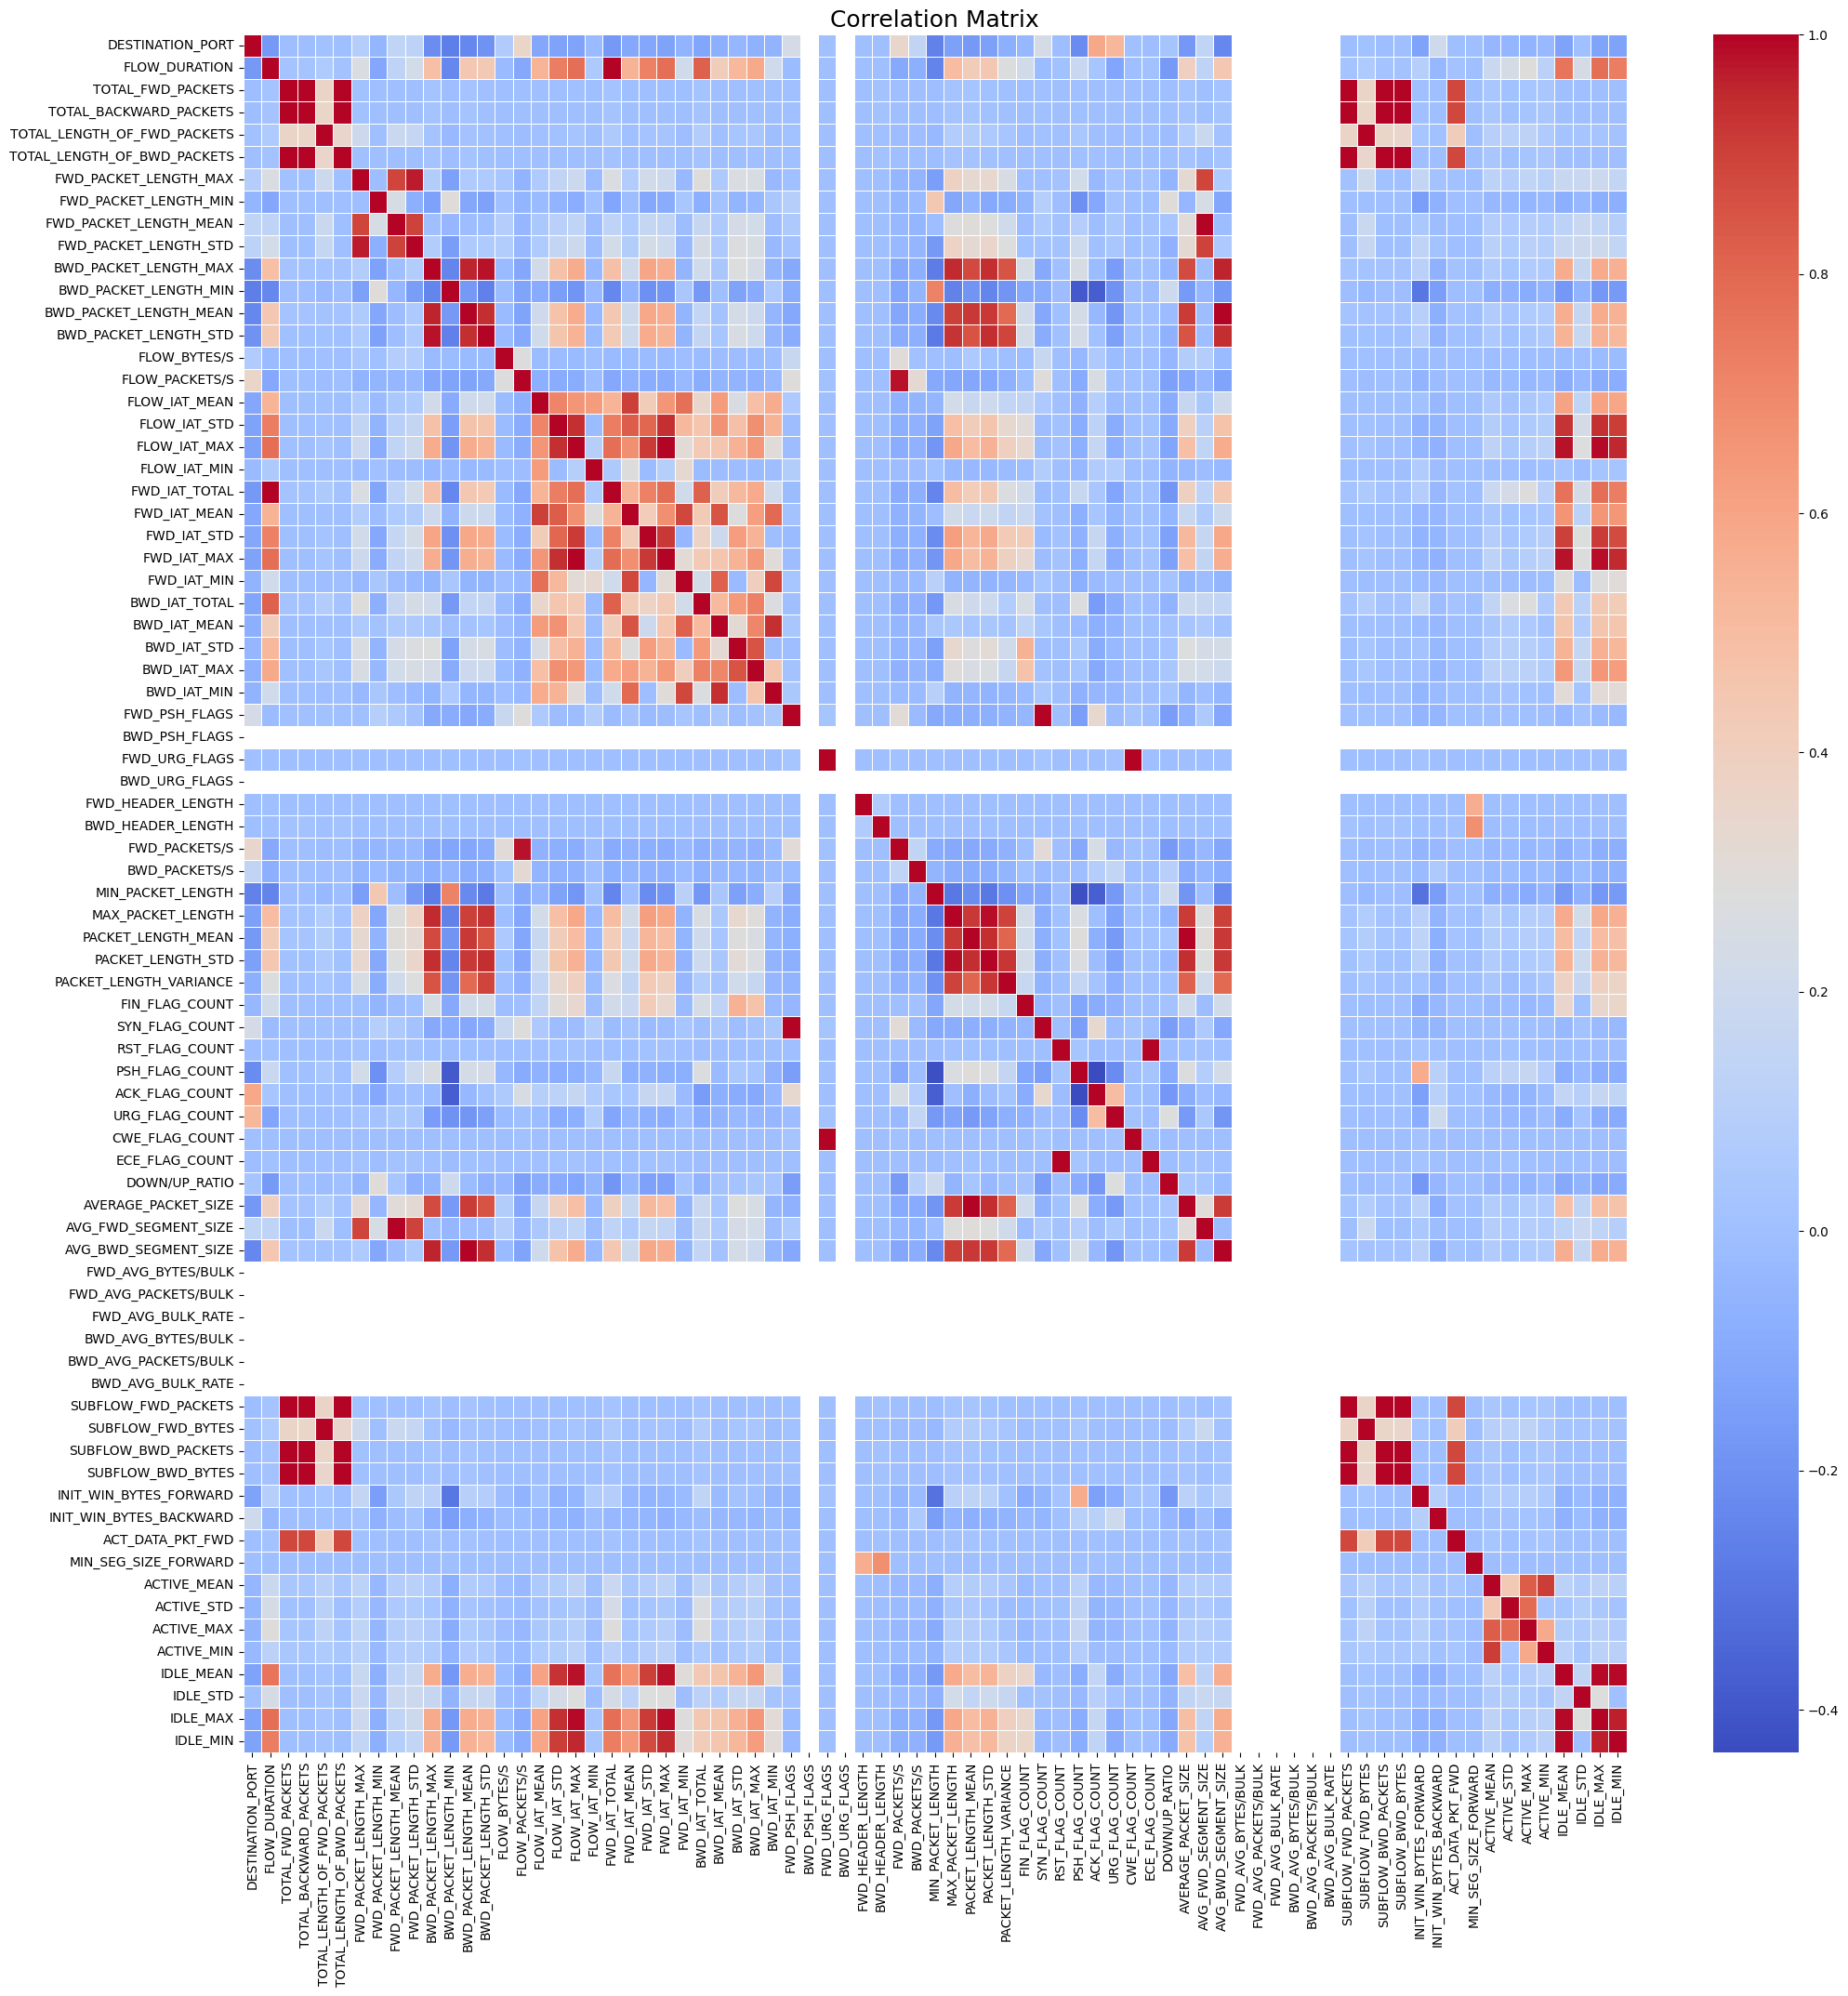

In [25]:
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

In [26]:
results = []

for feature in X.columns:
    for attack in merged_df['LABEL'].unique():
        subset = merged_df[merged_df['LABEL'] == attack][feature]
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = ((subset < lower_bound) | (subset > upper_bound)).sum()
        percent_outliers = (outlier_count / len(subset)) * 100 if len(subset) > 0 else 0
        results.append({
            "Feature-Attack Type": f"{feature} {attack}",
            "Percentage of Outliers": percent_outliers
        })

df_plot = pd.DataFrame(results)
df_plot = df_plot[df_plot["Percentage of Outliers"] > 20]

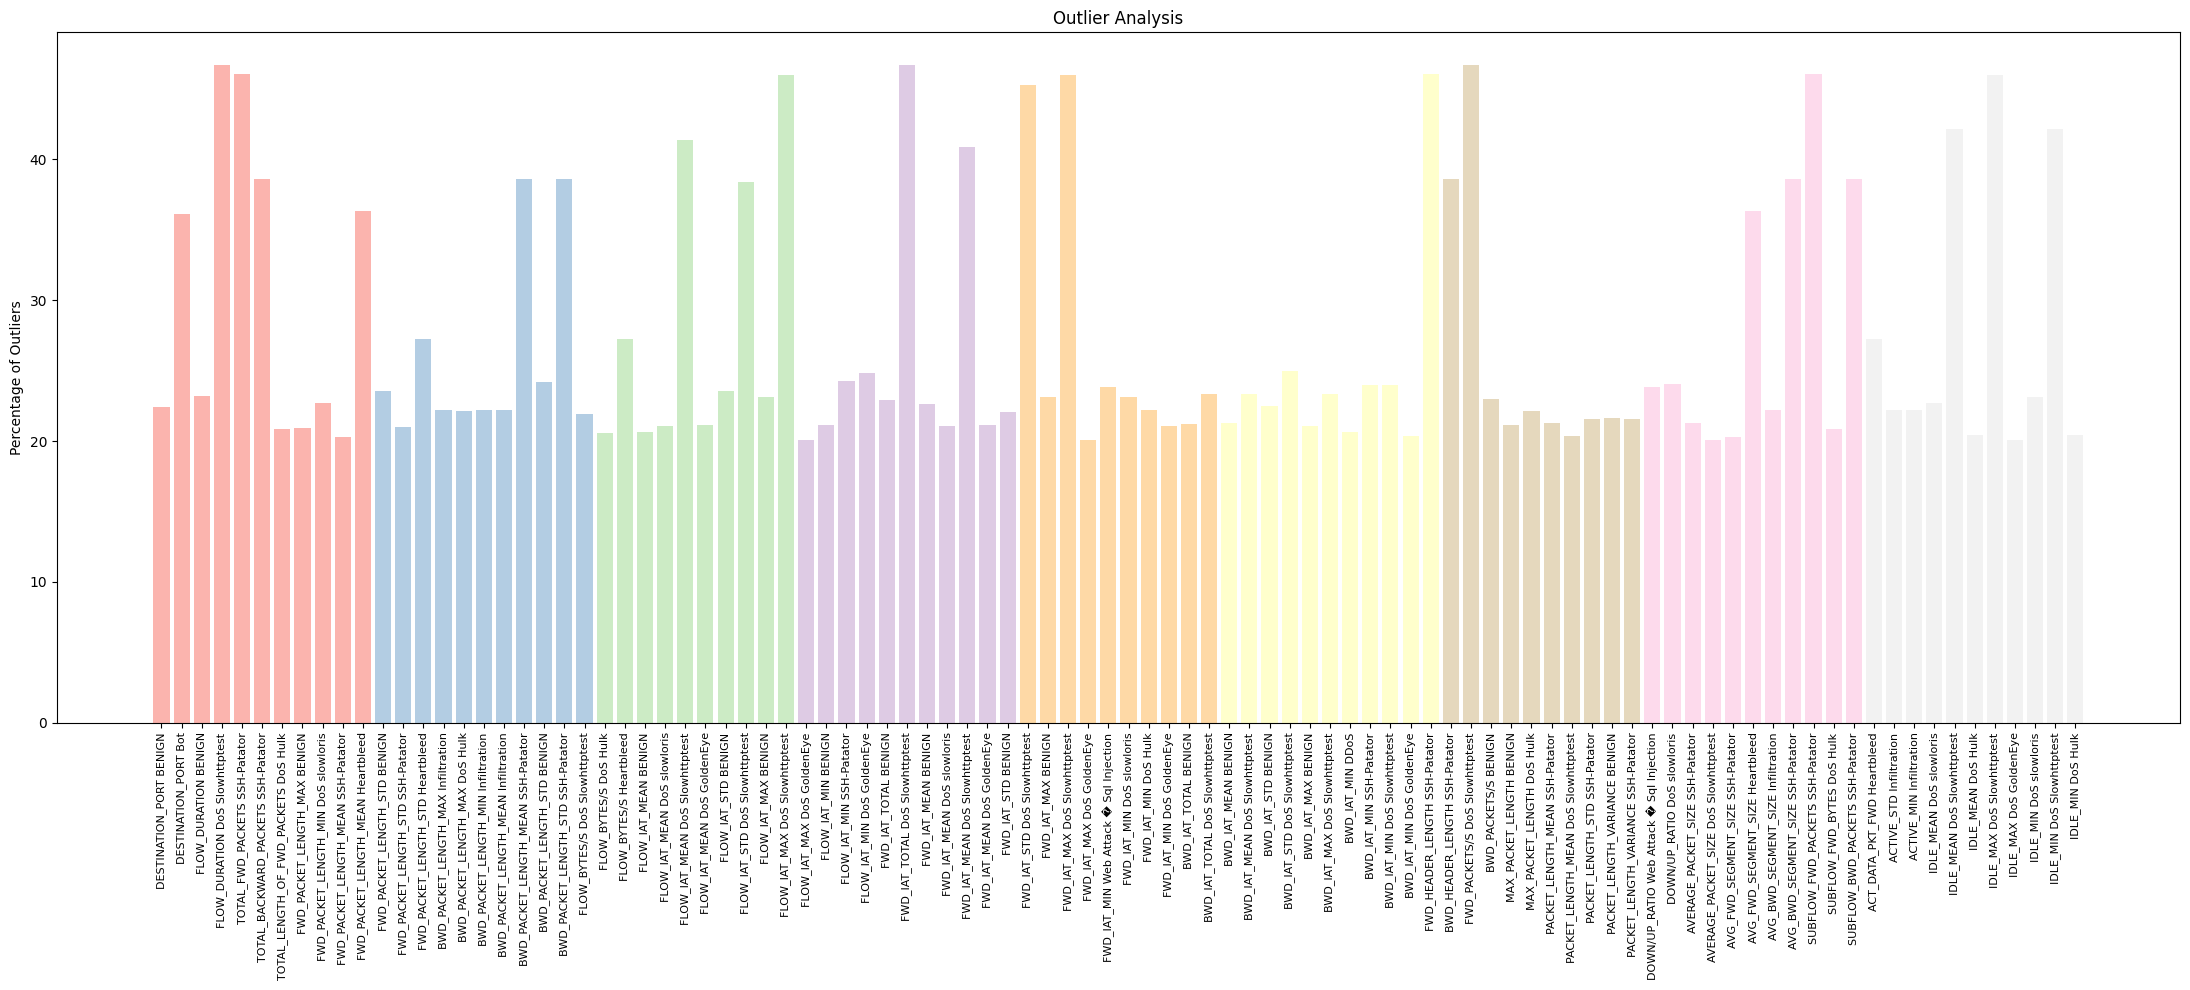

In [27]:
plt.figure(figsize = (22, 10))
cmap = plt.get_cmap('Pastel1')
colors = cmap(np.linspace(0, 1, len(df_plot)))
plt.bar(df_plot["Feature-Attack Type"], df_plot["Percentage of Outliers"], color = colors)
plt.xticks(rotation = 90, fontsize = 8)
plt.ylabel("Percentage of Outliers")
plt.title("Outlier Analysis")
plt.tight_layout()
plt.show()

<h5>Dataset Tagging and Symbolic Scoring</h5>

In [28]:
def profile_dataset_and_assign_tags(X, y):
    n_samples, n_features = X.shape
    anomaly_ratio = np.mean(y)
    missing_ratio = X.isna().sum().sum() / (n_samples * n_features)

    skewness = stats.skew(X, axis = 0, nan_policy = "omit")
    kurtosis = stats.kurtosis(X, axis = 0, nan_policy = "omit")
    avg_skewness = np.nanmean(np.abs(skewness))
    avg_kurtosis = np.nanmean(np.abs(kurtosis))

    tags = []

    # Dimensionality
    if n_features <= 10:
        tags.append("low_dimensional")
    elif n_features <= 100:
        tags.append("medium_dimensional")
    else:
        tags.append("high_dimensional")

    # Sample Size
    if n_samples <= 500:
        tags.append("small_sample")
    elif n_samples <= 5000:
        tags.append("medium_sample")
    else:
        tags.append("large_sample")

    # Imbalance
    if anomaly_ratio < 0.05:
        tags.append("highly_imbalanced")
    elif anomaly_ratio < 0.20:
        tags.append("imbalanced")
    else:
        tags.append("balanced")

    # Noise Estimation
    if avg_skewness > 2.5 or avg_kurtosis > 10:
        tags.append("noisy")
    else:
        tags.append("low_noise")

    # Missing Data
    if missing_ratio > 0.1:
        tags.append("missing_data")

    # Structure assumption (tabular)
    tags.append("structured_data")

    # Build summary table
    metrics_df = pd.DataFrame({
        "Metric": [
            "n_samples", "n_features", "anomaly_ratio",
            "missing_value_ratio", "avg_skewness", "avg_kurtosis"
        ],
        "Value": [
            n_samples, n_features, round(anomaly_ratio, 6),
            round(missing_ratio, 6), round(avg_skewness, 4),
            round(avg_kurtosis, 4)
        ]
    })

    print("Dataset Profiling Summary")
    display(metrics_df)

    print("\n Assigned Tags:", tags)
    return tags, metrics_df

In [29]:
assigned_tags, metrics_df = profile_dataset_and_assign_tags(X_train, y_train)

all_dataset_results = []

all_dataset_results.append({
    "name": "CICIDS2017.csv",
    "tags": assigned_tags,
    "metrics": metrics_df.to_dict(orient = "records")
})

Dataset Profiling Summary


,Metric,Value
0,n_samples,1.765653e+06
1,n_features,7.700000e+01
2,anomaly_ratio,1.688410e-01
3,missing_value_ratio,0.000000e+00
4,avg_skewness,9.167770e+01
5,avg_kurtosis,5.885434e+04



 Assigned Tags: ['medium_dimensional', 'large_sample', 'imbalanced', 'noisy', 'structured_data']


In [30]:
model_tag_dict = {
    "auto_encoder": {
        "strengths": ["structured_data", "low_noise", "medium_dimensional", "small_sample"],
        "weaknesses": ["noisy", "very_high_dimensional"]
    },
    "vae": {
        "strengths": ["structured_data", "low_noise", "medium_dimensional"],
        "weaknesses": ["small_sample", "noisy"]
    },
    "iforest": {
        "strengths": ["structured_data", "medium_dimensional", "small_sample"],
        "weaknesses": ["very_high_dimensional", "extremely_balanced"]
    },
    "lof": {
        "strengths": ["structured_data", "local_outliers", "medium_dimensional"],
        "weaknesses": ["very_large", "high_noise"]
    },
    "devnet": {
        "strengths": ["deep_outliers", "structured_data"],
        "weaknesses": ["small_sample", "imbalanced"]
    },
    "cblof": {
        "strengths": ["structured_data", "low_noise", "large_sample"],
        "weaknesses": ["very_small_sample"]
    },
    "kNN": {
        "strengths": ["structured_data", "local_outliers", "low_noise"],
        "weaknesses": ["high_dimensional", "large_sample"]
    },
    "HBOS": {
        "strengths": ["structured_data", "high_dimensional", "low_noise"],
        "weaknesses": ["noisy", "non_numerical"]
    },
    "PCA": {
        "strengths": ["low_noise", "structured_data", "high_dimensional"],
        "weaknesses": ["non_linear", "imbalanced"]
    },
    "COPOD": {
        "strengths": ["structured_data", "low_noise", "interpretability"],
        "weaknesses": ["non_numerical"]
    }
}

In [31]:
def score_models_by_tags(dataset_tags, model_tag_dict):
    results = []
    for model, tags in model_tag_dict.items():
        score = 0
        explanation = []
        for tag in tags.get("strengths", []):
            if tag in dataset_tags:
                score += 1
                explanation.append(f"+1 for {tag}")
        for tag in tags.get("weaknesses", []):
            if tag in dataset_tags:
                score -= 1
                explanation.append(f"-1 for {tag}")
        results.append({
            "Model": model,
            "Symbolic Score": score,
            "Explanation": "; ".join(explanation)
        })
    return pd.DataFrame(results).sort_values(by="Symbolic Score", ascending=False).reset_index(drop=True)

score_models_by_tags(assigned_tags, model_tag_dict)

,Model,Symbolic Score,Explanation
0,lof,2,+1 for structured_data; +1 for medium_dimensional
1,iforest,2,+1 for structured_data; +1 for medium_dimensional
2,cblof,2,+1 for structured_data; +1 for large_sample
3,auto_encoder,1,+1 for structured_data; +1 for medium_dimensio...
4,vae,1,+1 for structured_data; +1 for medium_dimensio...
5,COPOD,1,+1 for structured_data
6,devnet,0,+1 for structured_data; -1 for imbalanced
7,kNN,0,+1 for structured_data; -1 for large_sample
8,HBOS,0,+1 for structured_data; -1 for noisy
9,PCA,0,+1 for structured_data; -1 for imbalanced


In [35]:
def symbolic_model_selector(dataset_tags, model_tags_dict, tag_weights):
    results = []
    for model_name, tags in model_tags_dict.items():
        score = 0
        reasoning = []
        for tag in dataset_tags:
            weight = tag_weights.get(tag, 1.0)
            if tag in tags.get('strengths', []):
                score += weight
                reasoning.append(f"+{weight} for {tag}")
            elif tag in tags.get('weaknesses', []):
                score -= weight
                reasoning.append(f"-{weight} for {tag}")
        results.append({
            "Model": model_name,
            "Symbolic Score": score,
            "Explanation": "; ".join(reasoning)
        })

    results_df = pd.DataFrame(sorted(results, key = lambda x: -x["Symbolic Score"]))
    display(results_df)

    top_models = results_df[results_df["Symbolic Score"] == results_df["Symbolic Score"].max()]["Model"].tolist()

    gpt_prompt = f"""
Dataset Tags: {dataset_tags}

Model Tag Summaries:
{json.dumps(model_tags_dict, indent=2)}

Symbolic Scores:
{results_df.to_string(index=False)}

Do you agree with selecting **{top_models[0]}**? Why or why not?
""".strip()

    return results_df, gpt_prompt, top_models

In [33]:
TAG_WEIGHTS = {
    "low_noise": 1.0,
    "structured_data": 1.0,
    "balanced": 1.0,
    "small_sample": 0.8,
    "highly_imbalanced": 1.2,
    "noisy": 1.2,
    "high_dimensional": 1.1
}

In [36]:
symbolic_model_selector(assigned_tags, model_tag_dict, TAG_WEIGHTS)

,Model,Symbolic Score,Explanation
0,iforest,2.0,+1.0 for medium_dimensional; +1.0 for structur...
1,lof,2.0,+1.0 for medium_dimensional; +1.0 for structur...
2,cblof,2.0,+1.0 for large_sample; +1.0 for structured_data
3,COPOD,1.0,+1.0 for structured_data
4,auto_encoder,0.8,+1.0 for medium_dimensional; -1.2 for noisy; +...
5,vae,0.8,+1.0 for medium_dimensional; -1.2 for noisy; +...
6,devnet,0.0,-1.0 for imbalanced; +1.0 for structured_data
7,kNN,0.0,-1.0 for large_sample; +1.0 for structured_data
8,PCA,0.0,-1.0 for imbalanced; +1.0 for structured_data
9,HBOS,-0.2,-1.2 for noisy; +1.0 for structured_data


(          Model  Symbolic Score  \
 0       iforest             2.0   
 1           lof             2.0   
 2         cblof             2.0   
 3         COPOD             1.0   
 4  auto_encoder             0.8   
 5           vae             0.8   
 6        devnet             0.0   
 7           kNN             0.0   
 8           PCA             0.0   
 9          HBOS            -0.2   
 
                                          Explanation  
 0  +1.0 for medium_dimensional; +1.0 for structur...  
 1  +1.0 for medium_dimensional; +1.0 for structur...  
 2    +1.0 for large_sample; +1.0 for structured_data  
 3                           +1.0 for structured_data  
 4  +1.0 for medium_dimensional; -1.2 for noisy; +...  
 5  +1.0 for medium_dimensional; -1.2 for noisy; +...  
 6      -1.0 for imbalanced; +1.0 for structured_data  
 7    -1.0 for large_sample; +1.0 for structured_data  
 8      -1.0 for imbalanced; +1.0 for structured_data  
 9           -1.2 for noisy; +1.0 for stru

<h5>Model Training and Evaluation</h5>

In [ ]:
models = {
    "Isolation Forest": IForest(),
    "AutoEncoder": AutoEncoder(hidden_neuron_list = [64, 32, 32, 64], epoch_num = 30, batch_size = 256, verbose = 0),
    "VAE": VAE(epoch_num = 30, batch_size = 256, verbose = 0),
    "LOF": LOF()
}

results = {}

for name, model in models.items():
    print(f"\n----- Training: {name} -----")
    # Fit on train set
    model.fit(X_train_scaled)
    
    # Predict on test set
    y_test_pred = model.predict(X_test_scaled)  # 0: normal, 1: outlier
    y_test_score = model.decision_function(X_test_scaled)
    
    # Evaluation metrics
    roc_auc = roc_auc_score(y_test, y_test_score)
    ap = average_precision_score(y_test, y_test_score)
    report = classification_report(y_test, y_test_pred, target_names = ["Benign", "Attack"])
    
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {ap:.4f}")
    print("Classification Report:")
    print(report)
    
    results[name] = {
        "roc_auc": roc_auc,
        "average_precision": ap,
        "report": report,
    }


----- Training: Isolation Forest -----
ROC AUC: 0.7521
Average Precision: 0.3321
Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.93      0.89    628946
      Attack       0.42      0.25      0.32    127763

    accuracy                           0.82    756709
   macro avg       0.64      0.59      0.60    756709
weighted avg       0.79      0.82      0.80    756709


----- Training: AutoEncoder -----
ROC AUC: 0.6861
Average Precision: 0.2469
Classification Report:
              precision    recall  f1-score   support

      Benign       0.84      0.91      0.87    628946
      Attack       0.25      0.15      0.19    127763

    accuracy                           0.78    756709
   macro avg       0.55      0.53      0.53    756709
weighted avg       0.74      0.78      0.76    756709


----- Training: VAE -----
ROC AUC: 0.6814
Average Precision: 0.3489
Classification Report:
              precision    recall  f1-score   sup

<h5>Model Performance Evaluation</h5>

In [1]:
results = {
    "Isolation Forest": {
        "roc_auc": 0.7521,
        "average_precision": 0.3321,
        "report": """              precision    recall  f1-score   support

      Benign       0.86      0.93      0.89    628946
      Attack       0.42      0.25      0.32    127763

    accuracy                           0.82    756709
   macro avg       0.64      0.59      0.60    756709
weighted avg       0.79      0.82      0.80    756709
"""
    },
    "AutoEncoder": {
        "roc_auc": 0.6861,
        "average_precision": 0.2469,
        "report": """              precision    recall  f1-score   support

      Benign       0.84      0.91      0.87    628946
      Attack       0.25      0.15      0.19    127763

    accuracy                           0.78    756709
   macro avg       0.55      0.53      0.53    756709
weighted avg       0.74      0.78      0.76    756709
"""
    },
    "VAE": {
        "roc_auc": 0.6814,
        "average_precision": 0.3489,
        "report": """              precision    recall  f1-score   support

      Benign       0.87      0.94      0.91    628946
      Attack       0.54      0.32      0.40    127763

    accuracy                           0.84    756709
   macro avg       0.71      0.63      0.65    756709
weighted avg       0.82      0.84      0.82    756709
"""
    }
}

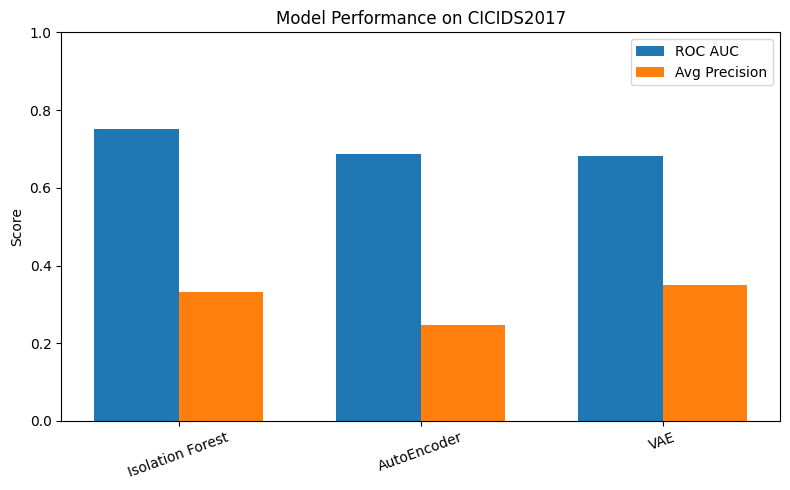

In [3]:
model_names = list(results.keys())
roc_aucs = [results[m]["roc_auc"] for m in model_names]
avg_precs = [results[m]["average_precision"] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize = (8, 5))
plt.bar(x - width / 2, roc_aucs, width, label = 'ROC AUC')
plt.bar(x + width / 2, avg_precs, width, label = 'Avg Precision')
plt.xticks(x, model_names, rotation = 20)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Model Performance on CICIDS2017")
plt.legend()
plt.tight_layout()
plt.show()